# Look at distributions of missingness

+ what are the contig lengths that aren't observed because there are not enough hashes?
+ how much more coverage do we get from the full database vs. the reps database

In [1]:
setwd("..")

In [2]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=7)
# disable scientific notation (for plot axes)
options(scipen = 999)

In [22]:
library(jsonlite)
library(dplyr)
library(tidyr)
library(tibble)
library(purrr)
library(stringr)
library(ggplot2)

## Functions

In [5]:
read_contigs_tax <- function(contigs_tax_path){  
  json <- fromJSON(contigs_tax_path)
  contig_tax_all <- data.frame()
  for(i in 1:length(json)){
    contig_name <- names(json)[i]
    basepairs <- json[[i]][[1]]
    hashes <- json[[i]][[2]]
    if(length(json[[i]][[3]]) > 0){
      lineage <- json[[i]][[3]][[1]][[1]][,2]
      lineage = paste(lineage, collapse = ";", sep = ";")
      matched_hashes <- json[[i]][[3]][[1]][[2]]
    } else {
      lineage = NA
      matched_hashes = NA
    }
    contig_tax <- data.frame(contig_name, basepairs, hashes, lineage, matched_hashes)
    contig_tax_all <- bind_rows(contig_tax_all, contig_tax)
  }
   contig_tax_all$genome <- gsub(".contigs-tax.json", "", basename(contigs_tax_path))
   return(contig_tax_all)
}

## Read in contig-level summaries

In [6]:
files_full <- Sys.glob("outputs/gtdb_rs202_charcoal1/stage1/*contigs-tax.json")
files_full_nonempty <- character()
for(i in 1:length(files_full)){
    tmp <- fromJSON(files_full[i])
    if(length(tmp) > 0){
        files_full_nonempty <- c(files_full_nonempty, files_full[i])
    }
}

In [7]:
contig_tax_full <- files_full_nonempty %>%
  map_dfr(read_contigs_tax)

In [8]:
files_reps <- Sys.glob("outputs/gtdb_rs202_charcoal1_reps/stage1/*contigs-tax.json")
files_reps_nonempty <- character()
for(i in 1:length(files_reps)){
    tmp <- fromJSON(files_reps[i])
    if(length(tmp) > 0){
        files_reps_nonempty <- c(files_reps_nonempty, files_reps[i])
    }
}

In [9]:
contig_tax_reps <- files_reps_nonempty %>%
  map_dfr(read_contigs_tax)

In [10]:
# set database name
contig_tax_full$database <- "full"
contig_tax_reps$database <- "reps"
# combine and set NAs as zeros
contig_tax <- bind_rows(contig_tax_full, contig_tax_reps) %>% 
  replace_na(list(hashes = 0, matched_hashes = 0))

In [11]:
colnames(contig_tax)

[1] "contig_name"    "basepairs"      "hashes"         "lineage"       
[5] "matched_hashes" "genome"         "database"

In [29]:
contig_tax_small_hash <- contig_tax %>%
  filter(hashes <= 9)

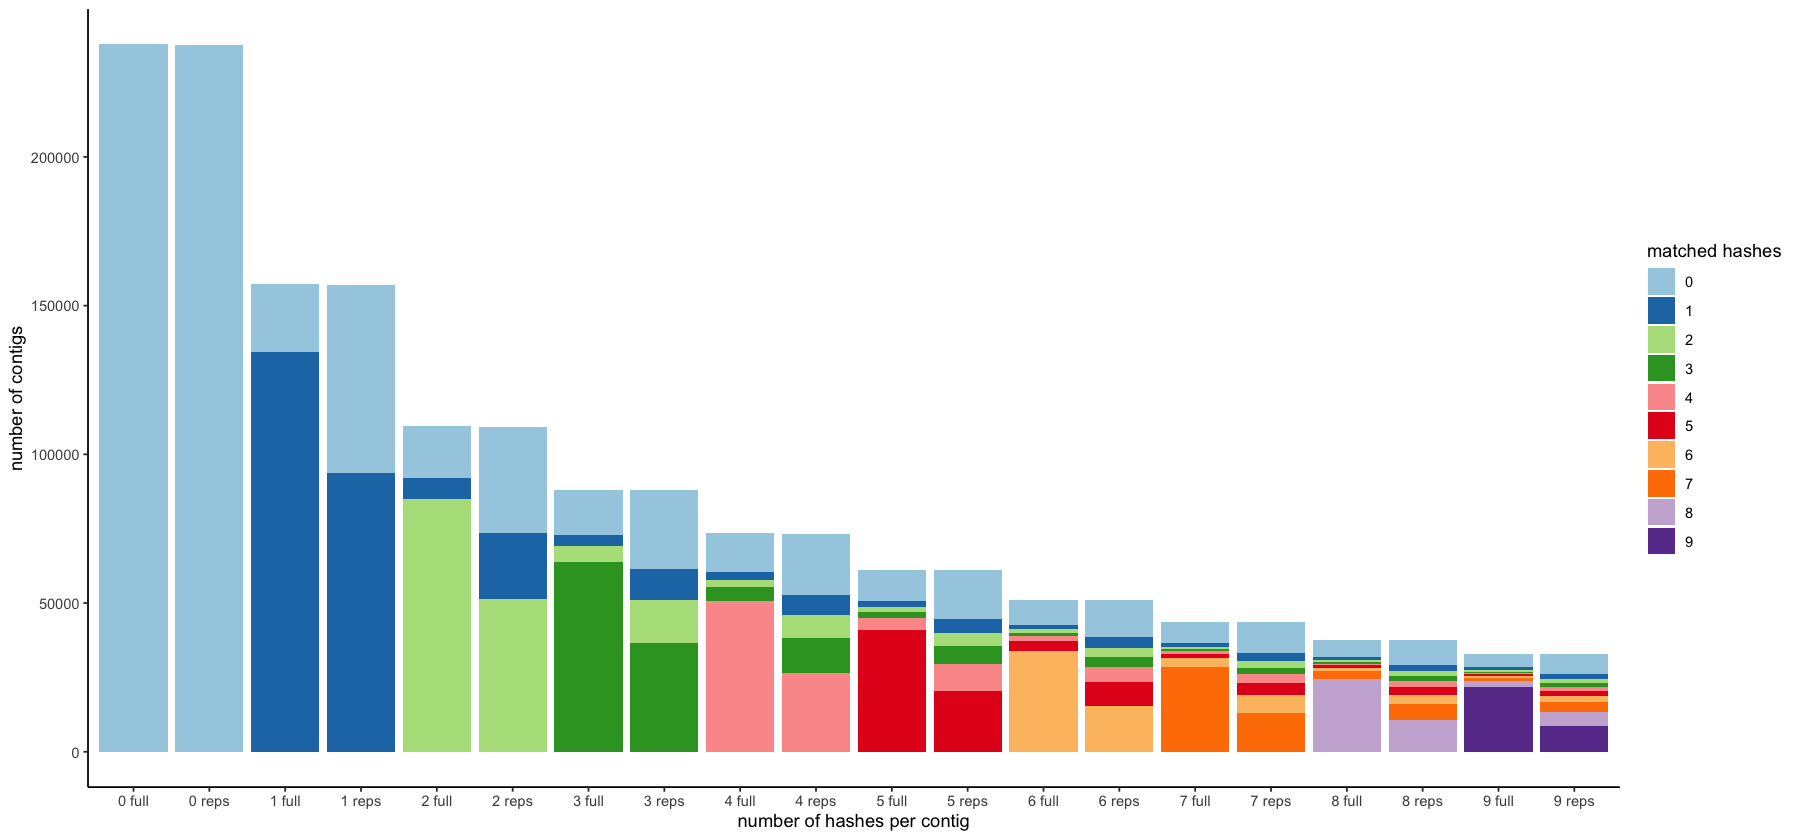

In [30]:
contig_tax_small_hash %>%
  group_by(hashes, matched_hashes, database) %>%
  tally() %>%
  mutate(hashes_database = paste(hashes, database, sep = " ")) %>%
  ggplot(aes(x = hashes_database, y = n, fill = as.factor(matched_hashes))) +
  geom_col() +
  theme_classic() +
  scale_fill_brewer(palette = "Paired") +
  labs(x = "number of hashes per contig", y = "number of contigs", fill = "matched hashes")


In [15]:
contig_tax_small_hash %>%
  group_by(hashes, matched_hashes, database) %>%
  tally() %>%
head()

hashes,matched_hashes,database,n
<int>,<int>,<chr>,<int>
0,0,full,237797
0,0,reps,237744
1,0,full,22792
1,0,reps,63430
1,1,full,134358
1,1,reps,93589


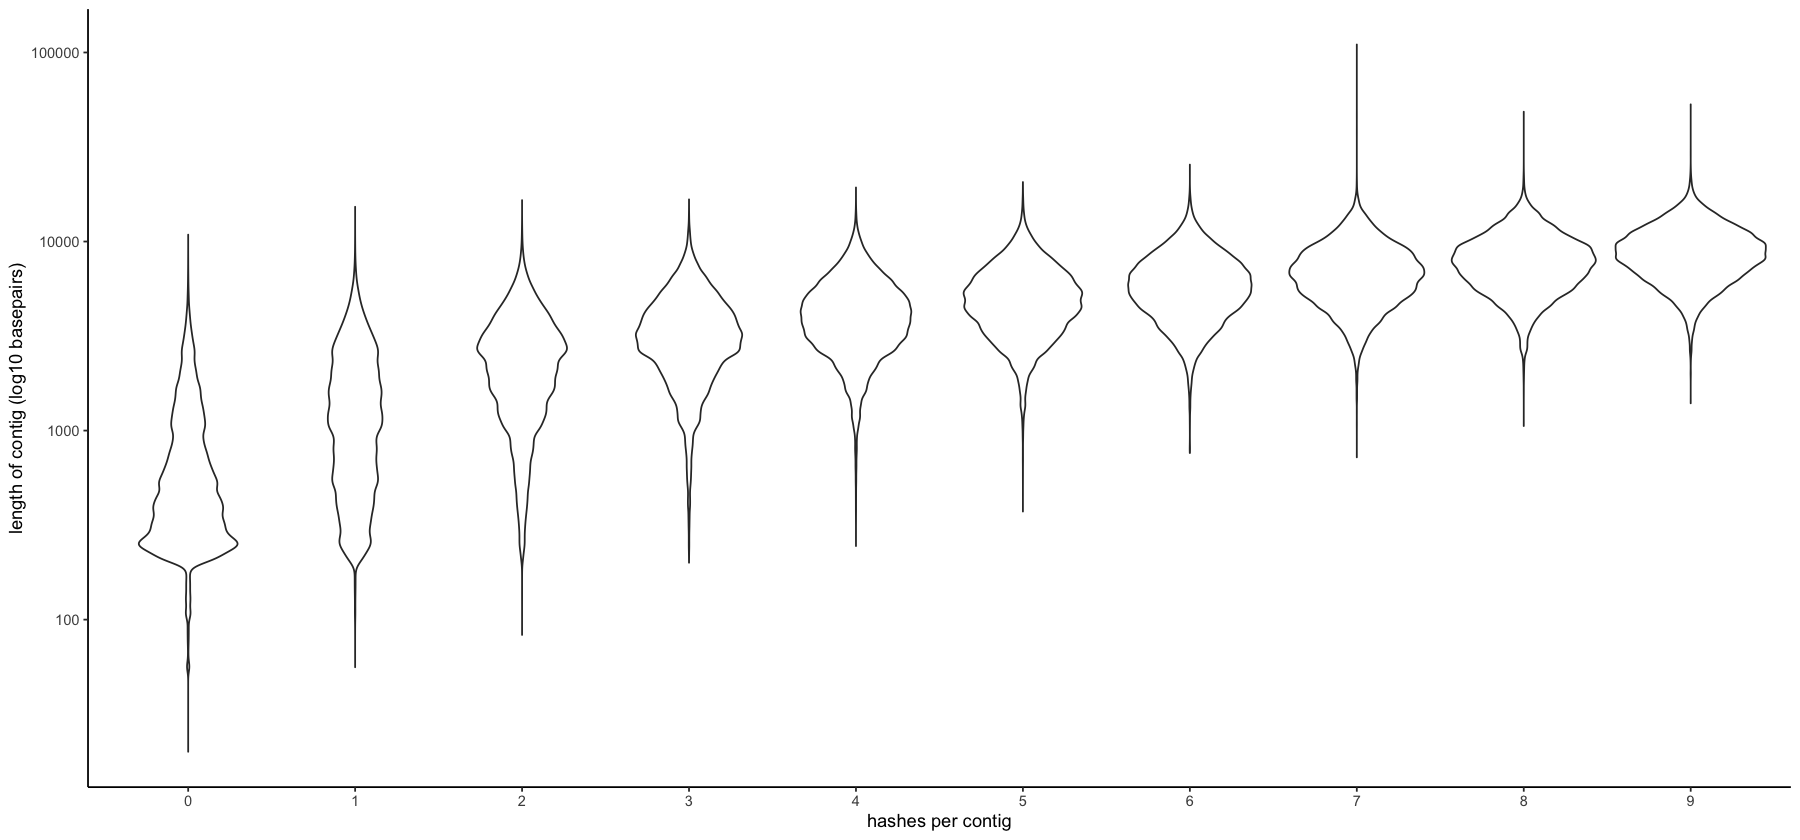

In [19]:
# number of hashes per contig, distributed by length
# any contig with fewer than 3 hashes will never be observed by charcoal
ggplot(contig_tax_full %>% filter(hashes < 10), aes(x = as.factor(hashes), y = basepairs)) + 
  geom_violin() +
  theme_classic() +
  scale_y_log10() +
  labs(x = "hashes per contig", y = "length of contig (log10 basepairs)")